# Multiple Persisten Faults Attack - Faulty AES

## License

```
Copyright (C) 2021  Hosein Hadipour
This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.
You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

**Required Packages**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp, log2
import random
from multiprocessing import Pool
from scipy.optimize import curve_fit
import pickle
from statistics import mean, variance

**Initialize Random Generator**

`random.seed(a=None, version=2)`

If a is omitted or None, the current system time is used. If randomness sources are provided by the operating system, they are used instead of the system time (see the os.urandom() function for details on availability).

`random.sample(population, k, *, counts=None)`

Returns a k length list of unique elements chosen from the population sequence or set. Used for random sampling without replacement.

`sample()` is used for random sampling without replacement, and `choices()` is used for random sampling with replacement.

**Generate A Random Faulty S-box**

In [5]:
def gen_random_faulty_sbox(number_of_faults, sbox):
    sbox_values_set = set(sbox)
    random_positions = random.sample(range(0, len(sbox)), number_of_faults)
    original_values = [sbox[i] for i in random_positions]
    original_values_complement = list(sbox_values_set.difference(set(original_values)))
    faulty_values = random.sample(original_values_complement, number_of_faults)
    dictionary_of_replacement = dict(zip(original_values, faulty_values))
    print('Dictionary of replacement: %s' % dictionary_of_replacement)
    faulty_sbox = [0]*len(sbox)
    for i in range(len(sbox)):
        if i in random_positions:
            faulty_sbox[i] = dictionary_of_replacement[sbox[i]]
        else:
            faulty_sbox[i] = sbox[i]
    return faulty_sbox

**Define S-box and Generate A Random Faulty S-box**

In [6]:
true_sbox = [
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
]
faulty_sbox = gen_random_faulty_sbox(number_of_faults=4, sbox=true_sbox)
print(faulty_sbox)

Dictionary of replacement: {73: 184, 159: 36, 123: 49, 59: 112}
[99, 124, 119, 49, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118, 202, 130, 201, 125, 250, 89, 71, 240, 173, 212, 162, 175, 156, 164, 114, 192, 183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216, 49, 21, 4, 199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117, 9, 131, 44, 26, 27, 110, 90, 160, 82, 112, 214, 179, 41, 227, 47, 132, 83, 209, 0, 237, 32, 252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207, 208, 239, 170, 251, 67, 77, 51, 133, 69, 249, 2, 127, 80, 60, 36, 168, 81, 163, 64, 143, 146, 157, 56, 245, 188, 182, 218, 33, 16, 255, 243, 210, 205, 12, 19, 236, 95, 151, 68, 23, 196, 167, 126, 61, 100, 93, 25, 115, 96, 129, 79, 220, 34, 42, 144, 136, 70, 238, 184, 20, 222, 94, 11, 219, 224, 50, 58, 10, 184, 6, 36, 92, 194, 211, 172, 98, 145, 149, 228, 121, 231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234, 101, 122, 174, 8, 186, 120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75, 

**Define Harmonic Number**

In [7]:
from fractions import Fraction
harmonic_number = lambda n: float(sum(Fraction(1, d) for d in range(1, n+1)))

## Implement (Faulty) AES-128

* In the following implementation it is supposed that key schedule is not effeccted by the faults

In [8]:
xtime = lambda a: (((a << 1) ^ 0x1B) & 0xFF) if (a & 0x80) else (a << 1)

def text2matrix(text):
    matrix = []
    for i in range(16):
        byte = (text >> (8 * (15 - i))) & 0xFF
        if i % 4 == 0:
            matrix.append([byte])
        else:
            matrix[i // 4].append(byte)
    return matrix

def matrix2text(matrix):
    text = 0
    for i in range(4):
        for j in range(4):
            text |= (matrix[i][j] << (120 - 8 * (4 * i + j)))
    return text

class AES:
    def __init__(self, master_key):
        self.Rcon = (
                        0x00, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40,
                        0x80, 0x1B, 0x36, 0x6C, 0xD8, 0xAB, 0x4D, 0x9A,
                        0x2F, 0x5E, 0xBC, 0x63, 0xC6, 0x97, 0x35, 0x6A,
                        0xD4, 0xB3, 0x7D, 0xFA, 0xEF, 0xC5, 0x91, 0x39,
                    )
        self.sbox = [
                        0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
                        0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
                        0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
                        0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
                        0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
                        0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
                        0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
                        0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
                        0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
                        0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
                        0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
                        0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
                        0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
                        0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
                        0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
                        0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16,
                    ]
        self.change_key(master_key)
    
    def apply_fault(self, number_of_fault):
        self.faulty_sbox = self.gen_random_faulty_sbox(number_of_fault)
        self.inv_faulty_sbox = [0]*(len(self.sbox))
        for i in range(len(self.faulty_sbox)):
            self.inv_faulty_sbox[self.faulty_sbox[i]] = i
    
    def gen_random_faulty_sbox(self, number_of_faults):
        sbox_values_set = set(self.sbox)
        random_positions = random.sample(range(len(self.sbox)), number_of_faults)
        original_values = [self.sbox[i] for i in random_positions]
        original_values_complement = list(sbox_values_set.difference(set(original_values)))
        faulty_values = random.sample(original_values_complement, number_of_faults)
        self.dictionary_of_replacement = dict(zip(original_values, faulty_values))
        faulty_sbox = [0]*256
        for i in range(256):
            if i in random_positions:
                faulty_sbox[i] = self.dictionary_of_replacement[self.sbox[i]]
            else:
                faulty_sbox[i] = self.sbox[i]
        return faulty_sbox

    def change_key(self, master_key):
        self.round_keys = text2matrix(master_key)
        # print(self.round_keys)

        for i in range(4, 4 * 11):
            self.round_keys.append([])
            if i % 4 == 0:
                byte = self.round_keys[i - 4][0]        \
                     ^ self.sbox[self.round_keys[i - 1][1]]  \
                     ^ self.Rcon[i // 4]
                self.round_keys[i].append(byte)

                for j in range(1, 4):
                    byte = self.round_keys[i - 4][j]    \
                         ^ self.sbox[self.round_keys[i - 1][(j + 1) % 4]]
                    self.round_keys[i].append(byte)
            else:
                for j in range(4):
                    byte = self.round_keys[i - 4][j]    \
                         ^ self.round_keys[i - 1][j]
                    self.round_keys[i].append(byte)

        # print(self.round_keys)
        return self.round_keys[40:44]

    def encrypt(self, plaintext):
        self.plain_state = text2matrix(plaintext)

        self.__add_round_key(self.plain_state, self.round_keys[:4])

        for i in range(1, 10):
            self.__round_encrypt(self.plain_state, self.round_keys[4 * i : 4 * (i + 1)])

        self.__sub_bytes(self.plain_state)
        self.__shift_rows(self.plain_state)
        self.__add_round_key(self.plain_state, self.round_keys[40:])

        return matrix2text(self.plain_state)

    def decrypt(self, ciphertext):
        self.cipher_state = text2matrix(ciphertext)

        self.__add_round_key(self.cipher_state, self.round_keys[40:])
        self.__inv_shift_rows(self.cipher_state)
        self.__inv_sub_bytes(self.cipher_state)

        for i in range(9, 0, -1):
            self.__round_decrypt(self.cipher_state, self.round_keys[4 * i : 4 * (i + 1)])

        self.__add_round_key(self.cipher_state, self.round_keys[:4])

        return matrix2text(self.cipher_state)

    def __add_round_key(self, s, k):
        for i in range(4):
            for j in range(4):
                s[i][j] ^= k[i][j]


    def __round_encrypt(self, state_matrix, key_matrix):
        self.__sub_bytes(state_matrix)
        self.__shift_rows(state_matrix)
        self.__mix_columns(state_matrix)
        self.__add_round_key(state_matrix, key_matrix)


    def __round_decrypt(self, state_matrix, key_matrix):
        self.__add_round_key(state_matrix, key_matrix)
        self.__inv_mix_columns(state_matrix)
        self.__inv_shift_rows(state_matrix)
        self.__inv_sub_bytes(state_matrix)

    def __sub_bytes(self, s):
        for i in range(4):
            for j in range(4):
                s[i][j] = self.faulty_sbox[s[i][j]]


    def __inv_sub_bytes(self, s):
        for i in range(4):
            for j in range(4):
                s[i][j] = self.inv_faulty_sbox[s[i][j]]


    def __shift_rows(self, s):
        s[0][1], s[1][1], s[2][1], s[3][1] = s[1][1], s[2][1], s[3][1], s[0][1]
        s[0][2], s[1][2], s[2][2], s[3][2] = s[2][2], s[3][2], s[0][2], s[1][2]
        s[0][3], s[1][3], s[2][3], s[3][3] = s[3][3], s[0][3], s[1][3], s[2][3]


    def __inv_shift_rows(self, s):
        s[0][1], s[1][1], s[2][1], s[3][1] = s[3][1], s[0][1], s[1][1], s[2][1]
        s[0][2], s[1][2], s[2][2], s[3][2] = s[2][2], s[3][2], s[0][2], s[1][2]
        s[0][3], s[1][3], s[2][3], s[3][3] = s[1][3], s[2][3], s[3][3], s[0][3]

    def __mix_single_column(self, a):
        # please see Sec 4.1.2 in The Design of Rijndael
        t = a[0] ^ a[1] ^ a[2] ^ a[3]
        u = a[0]
        a[0] ^= t ^ xtime(a[0] ^ a[1])
        a[1] ^= t ^ xtime(a[1] ^ a[2])
        a[2] ^= t ^ xtime(a[2] ^ a[3])
        a[3] ^= t ^ xtime(a[3] ^ u)


    def __mix_columns(self, s):
        for i in range(4):
            self.__mix_single_column(s[i])


    def __inv_mix_columns(self, s):
        # see Sec 4.1.3 in The Design of Rijndael
        for i in range(4):
            u = xtime(xtime(s[i][0] ^ s[i][2]))
            v = xtime(xtime(s[i][1] ^ s[i][3]))
            s[i][0] ^= u
            s[i][1] ^= v
            s[i][2] ^= u
            s[i][3] ^= v

        self.__mix_columns(s)

## Using NIST Test Vectors to Verify the Correctness of AES Implementation
Reference: Test vectors have been taken from [NIST](https://csrc.nist.gov/CSRC/media/Projects/Cryptographic-Standards-and-Guidelines/documents/examples/AES_Core128.pdf)

In [9]:
master_key = 0x2B7E151628AED2A6ABF7158809CF4F3C
plaintext = 0x6BC1BEE22E409F96E93D7E117393172A
expected_ciphertext = 0x3AD77BB40D7A3660A89ECAF32466EF97
faulty_aes = AES(master_key)
faulty_aes.apply_fault(number_of_fault=0)
derived_ciphertext = faulty_aes.encrypt(plaintext)
if derived_ciphertext == expected_ciphertext:
    print("AES encryption works correctly :-)")
else:
    print("AES encryption doesn't work correctly :-(")
derived_plaintext = faulty_aes.decrypt(derived_ciphertext)
print("derived ciphertext:\t %s" % hex(derived_ciphertext).upper())
print("expected ciphertext:\t %s" % hex(expected_ciphertext).upper())
if derived_ciphertext == expected_ciphertext:
    print("AES decryption works correctly :-)")
else:
    print("AES decryption doesn't work correctly :-(")
print("derived plaintext:\t %s" % hex(derived_plaintext).upper())
print("expected plaintext:\t %s" % hex(plaintext).upper())

AES encryption works correctly :-)
derived ciphertext:	 0X3AD77BB40D7A3660A89ECAF32466EF97
expected ciphertext:	 0X3AD77BB40D7A3660A89ECAF32466EF97
AES decryption works correctly :-)
derived plaintext:	 0X6BC1BEE22E409F96E93D7E117393172A
expected plaintext:	 0X6BC1BEE22E409F96E93D7E117393172A


## Experiment 1
Assuming that `number_of_faults` faults have been induced, we generate `N` random (faulty) ciphertexts and collect observed values at each output byte of ciphertexts. We repeat this experiment for several random master keys and aiming to see how many random queries is required on average to observe all possible values at least once for an arbitrary output byte of ciphertext.

In [10]:
def experiment1(number_of_experiments, number_of_faults, number_of_queries_in_each_exper):
    produced_ciphertexts = []
    number_of_observed_bytes_in_this_experiment = [[[] for _ in range(4)] for _ in range(4)]
    number_of_non_observed_bytes_in_this_experiment = [[[] for _ in range(4)] for _ in range(4)]
    reference_set = set(list(range(256)))
    for this_experiment in range(number_of_experiments):
        # Initialize a faulty AES for this experiment
        observed_bytes = [[[] for _ in range(4)] for _ in range(4)]
        master_key = random.getrandbits(128)
        faulty_aes = AES(master_key)
        faulty_aes.apply_fault(number_of_faults)
        for this_query in range(number_of_queries_in_each_exper):
            # Choose a plaintext at random
            plaintext = random.getrandbits(128)
            ciphertext = faulty_aes.encrypt(plaintext)
            ciphertext = text2matrix(ciphertext)
            for row in range(4):
                for col in range(4):
                    observed_bytes[col][row].append(ciphertext[col][row])
        for row in range(4):
            for col in range(4):
                observed = set(observed_bytes[col][row])
                non_observed = reference_set.difference(observed)
                # number_of_observed_bytes_in_this_experiment[row][col].append(len(observed))
                number_of_non_observed_bytes_in_this_experiment[col][row].append(len(non_observed))
        # Generate the set of differences for the the first cell
    mean_output = [[0 for _ in range(4)] for _ in range(4)]
    total_mean = 0
    for row in range(4):
        for col in range(4):
            mean_for_each_position = np.mean(number_of_non_observed_bytes_in_this_experiment[row][col])
            mean_output[col][row] = mean_for_each_position
            total_mean += mean_for_each_position
    total_mean = total_mean / 16.0
    return mean_output, total_mean

In [11]:
number_of_faults = 5
bias = 0
m = 2**8 - number_of_faults
expected_number_of_queries = int(np.ceil((m*harmonic_number(m)))) + bias
mean_output, total_mean = experiment1(number_of_experiments=10,\
                                      number_of_faults=number_of_faults,\
                                      number_of_queries_in_each_exper=expected_number_of_queries)
total_mean

5.5687500000000005

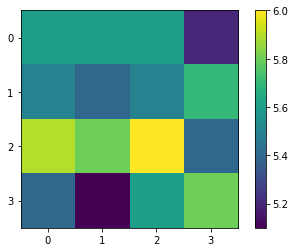

Number of non-observed values on average:
5.60, 5.60, 5.60, 5.20, 
5.50, 5.40, 5.50, 5.70, 
5.90, 5.80, 6.00, 5.40, 
5.40, 5.10, 5.60, 5.80, 
Number of faults: 5
Expected number of queries based on our paper: 1533


In [12]:
output = "Number of non-observed values on average:"
for row in range(4):
    output += "\n"
    for col in range(4):
        output += "%0.02f, " % mean_output[row][col]
plt.imshow(mean_output)
plt.xticks(range(4), range(4))
plt.yticks(range(4), range(4))
plt.colorbar()
plt.show()
print(output)
print('Number of faults: %d' % number_of_faults)
print('Expected number of queries based on our paper: %d' % expected_number_of_queries)

**Produce Diagrams**

In [13]:
def generate_digrams_data(number_of_faults=1,\
                          max_number_of_queries=1000,\
                          number_of_experiment_per_query=10):
    remained_deltas = []
    for nq in range(1, max_number_of_queries):
        mean_output, total_mean = experiment1(number_of_experiments=number_of_experiment_per_query,\
                                              number_of_faults=number_of_faults,\
                                              number_of_queries_in_each_exper=nq)
        remained_deltas.append(total_mean)
    return remained_deltas

**Generate (or Read) the Required Data to Plot a Figure for Number of Non-observed Values With Respect to the Number of Available Ciphertexts**

In [14]:
lam = 1

m = 2**8 - lam
expected_number_of_queries = int(np.ceil((m*harmonic_number(m))))
max_number_of_queries = expected_number_of_queries + 800
#################################################################
number_of_faults = range(1, 17)
flag = 'read_data'
if flag == 'compute_data':
    number_of_experiment_per_query = 10
    with Pool(16) as pool:
        arguments = [(nf, max_number_of_queries, number_of_experiment_per_query) for nf in number_of_faults]
        candidates = pool.starmap(generate_digrams_data, arguments)
    with open('candidates', 'wb') as f:
        pickle.dump(candidates, f)
elif flag == 'read_data':
    with open('candidates', 'rb') as f:
        candidates = pickle.load(f)

**The following vector includes the average number of non-observed values when the number of faults is equal to 1 and N known ciphertexts are available, where 1 <= N <= 2360:**


In [15]:
y_data_1 = candidates[0]
print(y_data_1)

[255.0, 254.00187500000004, 253.01125000000005, 252.020625, 251.044375, 250.0525, 249.0725, 248.116875, 247.1575, 246.1925, 245.21249999999998, 244.25624999999997, 243.31124999999997, 242.365625, 241.41187500000004, 240.44875, 239.52625, 238.600625, 237.65312500000002, 236.73374999999996, 235.823125, 234.853125, 233.94937499999995, 233.06187500000001, 232.148125, 231.23125, 230.303125, 229.49249999999998, 228.52937500000002, 227.64687500000002, 226.76937499999997, 225.95937500000002, 224.98687500000003, 224.080625, 223.258125, 222.34375, 221.54625000000004, 220.63500000000005, 219.820625, 218.97375000000002, 218.08625, 217.26437499999997, 216.36499999999998, 215.51187500000003, 214.614375, 213.80375, 213.00875, 212.22187499999998, 211.33875000000003, 210.556875, 209.718125, 208.85937500000003, 207.97250000000003, 207.23250000000002, 206.47062500000004, 205.62937499999998, 204.839375, 204.151875, 203.24375000000003, 202.42187499999997, 201.73624999999998, 200.840625, 200.02437500000002,

**Define The General Exponential Function to Fit on The Experimental Data**

In [16]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

**Plot the Number of Non-observed Values With Respect to the Number of Available Ciphertexts - Overview**

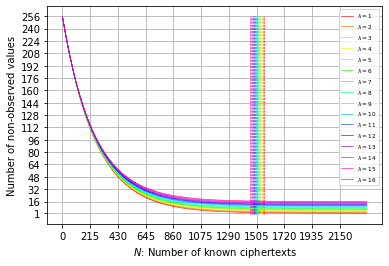

In [17]:
x_start_point = 1
x_end_point = max_number_of_queries
x_data = range(x_start_point, x_end_point)

y_start_point = 0
y_end_point = 256

cmap = plt.get_cmap('hsv')
colors = [cmap(i) for i in np.linspace(0, 1, 17)]
for i in range(len(number_of_faults)):
    y_data = candidates[i][x_start_point - 1:]
    plt.plot(x_data, y_data,\
             color=colors[i], label='$\lambda = %d$' % (i + 1), linewidth=0.6)
    m = 2**8 - (i + 1)
    expect_number_of_queries = np.ceil((m*harmonic_number(m)))
    plt.plot([expect_number_of_queries]*2, [y_start_point, y_end_point],\
                '--', color=colors[i], label='', linewidth=0.6)

plt.legend(fontsize='xx-small', ncol=1, loc='best')

x_tick_step = 215
y_tick_step = 16
plt.xticks(list(range(0, max_number_of_queries, x_tick_step)))
plt.yticks([1] + list(range(16, 260, y_tick_step)))
# plt.xlim(-100, 2000)
# plt.ylim(0, 260)
plt.grid(True)
plt.xlabel('$N$: Number of known ciphertexts')
plt.ylabel('Number of non-observed values')
# plt.show()
plt.savefig("overview_diagram_of_non_observed_values.svg", format='svg', dpi=1200)

**Plot the Number of Non-observed Values With Respect to The Number of Available Ciphertexts - Close up**

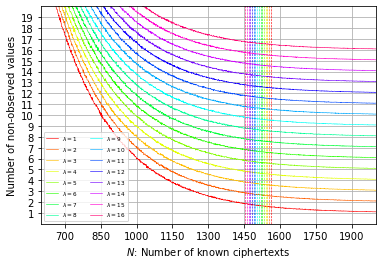

In [18]:
x_start_point = 1
x_end_point = max_number_of_queries
x_data = range(x_start_point, x_end_point)

y_start_point = 0
y_end_point = 256

cmap = plt.get_cmap('hsv')
colors = [cmap(i) for i in np.linspace(0, 1, 17)]
for i in range(len(number_of_faults)):
    y_data = candidates[i][x_start_point - 1:]
    plt.plot(x_data, y_data,\
             color=colors[i], label='$\lambda = %d$' % (i + 1), linewidth=0.6)
    m = 2**8 - (i + 1)
    expect_number_of_queries = np.ceil((m*harmonic_number(m)))
    plt.plot([expect_number_of_queries]*2, [y_start_point, y_end_point],\
                '--', color=colors[i], label='', linewidth=0.6)

plt.legend(fontsize='xx-small', ncol=2, loc='best')

x_tick_step = 150
y_tick_step = 1
plt.xticks(list(range(700, 2000, x_tick_step)))
plt.yticks(list(range(1, 20, y_tick_step)))
plt.xlim(600, 2000)
plt.ylim(0, 20)
plt.grid(True)
plt.xlabel('$N$: Number of known ciphertexts')
plt.ylabel('Number of non-observed values')
# plt.show()
plt.savefig("close_up_diagram_of_non_observed_values.svg", format='svg', dpi=1200)

**Fitt an Exponential Curve on the Derived Data - Overview**

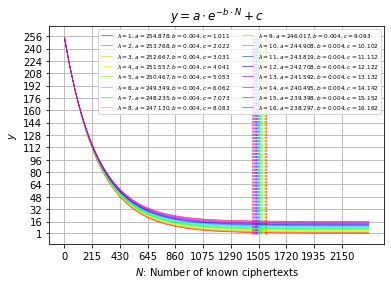

In [19]:
import warnings
warnings.filterwarnings('ignore')

x_start_point = 1
x_end_point = max_number_of_queries
x_data = np.arange(x_start_point, x_end_point)

y_start_point = 0
y_end_point = 256

cmap = plt.get_cmap('hsv')
colors = [cmap(i) for i in np.linspace(0, 1, 17)]
for i in range(len(number_of_faults)):
    y_data = candidates[i][x_start_point - 1:]
    # Fitt a curve to data
    popt, pcov = curve_fit(func, x_data, y_data)
    plt.plot(x_data, func(x_data, *popt),\
             color=colors[i],
             label='$\lambda = %d, a=%5.3f, b=%5.3f, c=%5.3f$' % (i + 1, *popt), linewidth=0.6)
    m = 2**8 - (i + 1)
    expect_number_of_queries = np.ceil((m*harmonic_number(m)))
    plt.plot([expect_number_of_queries]*2, [y_start_point, y_end_point],\
                '--', color=colors[i], label='', linewidth=0.6)

plt.legend(fontsize='xx-small', ncol=2, loc='best')
plt.title("$y = a \cdot e^{-b \cdot N} + c$")

x_tick_step = 215
y_tick_step = 16
plt.xticks(list(range(0, max_number_of_queries, x_tick_step)))
plt.yticks([1] + list(range(16, 260, y_tick_step)))
# plt.xlim(-100, 2000)
# plt.ylim(0, 260)
plt.grid(True)
plt.xlabel('$N$: Number of known ciphertexts')
plt.ylabel("$y$")
# plt.show()
plt.savefig("overview_fit_on_non_observed_values.svg", format='svg', dpi=1200)

**Fitt an Exponential Curve on The Derived Data - Close up**

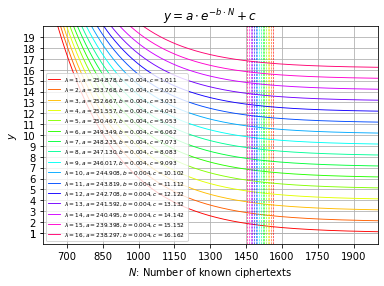

In [20]:
x_start_point = 1
x_end_point = max_number_of_queries
x_data = np.arange(x_start_point, x_end_point)

y_start_point = 0
y_end_point = 260

cmap = plt.get_cmap('hsv')
colors = [cmap(i) for i in np.linspace(0, 1, 17)]
for i in range(len(number_of_faults)):
    y_data = candidates[i][x_start_point - 1:]
    # Fitt a curve to data
    popt, pcov = curve_fit(func, x_data, y_data)
    plt.plot(x_data, func(x_data, *popt),\
             color=colors[i],
             label='$\lambda = %d, a=%5.3f, b=%5.3f, c=%5.3f$' % (i + 1, *popt), linewidth=0.9)
    # Draw a vertical line to show the expected number of queries based on our estimation
    m = 2**8 - (i + 1)
    expect_number_of_queries = np.ceil((m*harmonic_number(m)))
    plt.plot([expect_number_of_queries]*2, [y_start_point, y_end_point],\
                '--', color=colors[i], label='', linewidth=0.6)

plt.legend(fontsize='xx-small', ncol=1, loc='best')
plt.title("$y = a \cdot e^{-b \cdot N} + c$")

x_tick_step = 150
y_tick_step = 1
plt.xticks(list(range(700, 2000, x_tick_step)))
plt.yticks([1] + list(range(1, 20, y_tick_step)))
# plt.margins(x=0.05, y=0.05)
plt.xlim(600, 2000)
plt.ylim(0, 20)
plt.grid(True)
plt.xlabel('$N$: Number of known ciphertexts')
plt.ylabel('$y$')
# plt.legend(bbox_to_anchor=(-0.11, 0.5), loc='center right', fontsize='xx-small')
# plt.show()
plt.savefig("close_up_fit_on_non_obsereved_values.svg", format='svg', dpi=1200)

## Experiment 2 - Implement Algorithm 1 to Find deltaj = skR[0] + skR[j]
In this experiment we aim to check how Algorithm 1 in our paper works in practice.

In [21]:
def alg1_to_find_delta(D0, Dj, number_of_faults):
    delta_counters = dict()
    for ell in range(number_of_faults):
        alpha_l = D0[0] ^ Dj[ell]
        delta_counters[alpha_l] = 1
        Dtemp = set(Dj).difference(set([Dj[ell]]))
        for i in range(1, number_of_faults):
            E = D0[i] ^ alpha_l
            if E in Dtemp:
                delta_counters[alpha_l] += 1
                Dtemp = Dtemp.difference(set([E]))
    keys, values = delta_counters.keys(), delta_counters.values()
    plt.bar(keys, values)
    # print("Number of faults: %d" % number_of_faults)
    # print("Number of appearance for each delta:\n%s" % delta_counters)
    candidates = [delta for delta in delta_counters.keys() if delta_counters[delta] == number_of_faults]
    return candidates

**Run Faulty AES for Sufficiently Large Number of Random Plaintexts And Collect The Observed As Well As Non-observed Values for Each Output Byte**

In [22]:
def generate_deltas_for_large_number_of_ciphertexts(number_of_faults=2):
    m = 2**8 - number_of_faults
    number_of_random_plaintexts = 2*int(np.ceil(m*harmonic_number(m)))
    reference_set = set(list(range(256)))
    ##################################################################
    # Initialize a faulty AES for this experiment
    observed_bytes = [[[] for _ in range(4)] for _ in range(4)]
    non_observed_bytes = [[[] for _ in range(4)] for _ in range(4)]
    master_key = random.getrandbits(128)
    faulty_aes = AES(master_key)
    last_round_key = faulty_aes.round_keys[4*10:4*11]
    last_round_key = [last_round_key[j][i] for j in range(4) for i in range(4)]
    faulty_aes.apply_fault(number_of_faults)
    for this_query in range(number_of_random_plaintexts):
        # Choose a plaintext at random
        plaintext = random.getrandbits(128)
        ciphertext = faulty_aes.encrypt(plaintext)
        ciphertext = text2matrix(ciphertext)
        for col in range(4):
            for row in range(4):
                observed_bytes[col][row].append(ciphertext[col][row])
    for col in range(4):
        for row in range(4):
            observed = set(observed_bytes[col][row])
            non_observed_bytes[col][row] = list(reference_set.difference(observed))
    ##################################################################
    #print("Expected number of queries: %d, bias: %d" % (expect_number_of_queries, bias))
    D = [[] for _ in range(16)]
    for col in range(4):
        for row in range(4):
            j = 4*col + row
            D[j] = non_observed_bytes[col][row]
            # print('D_{%d}: %s' % (j, D[j]))
    return number_of_random_plaintexts, D, faulty_aes.dictionary_of_replacement, last_round_key

Number of available ciphertexts: 3080
Candidates for delta5: [223]
skR[0] xor skR[5]: 223


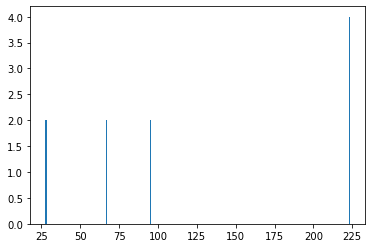

In [23]:
nf = 4
position = 5
number_of_ciphertexts, DD, true_fault_mapping, true_last_round_key =\
     generate_deltas_for_large_number_of_ciphertexts(number_of_faults=nf)
delta_candidates = alg1_to_find_delta(DD[0], DD[position], number_of_faults=nf)
print("Number of available ciphertexts: %d" % number_of_ciphertexts)
print("Candidates for delta%d: %s" % (position, delta_candidates))
print("skR[0] xor skR[%d]: %d" % (position, true_last_round_key[0] ^ true_last_round_key[position]))

## Experiment 3 - Implement Algorithm 2 to Find deltaj = skR[0] + skR[j]
In this experiment we aim to implement the algorithm 2 to see how it works in practice.

**Implement Algorithm 2 to Find deltaj = skR0 + skRj When a Limited Number of Known Ciphertexts is Available**

In [24]:
def find_delta_candidates(D0, Dj, number_of_faults):    
    lambda_prime = len(Dj)
    lambda_prime_zero = len(D0)
    final_candidates = []
    for k in range(lambda_prime_zero - number_of_faults + 1): # Iterating up to this number ensures a non-empty output
        candidates = []
        delta_counters = dict()
        for ell in range(lambda_prime):
            alpha_l = D0[k] ^ Dj[ell]
            delta_counters[alpha_l] = 1
            Dtemp = set(Dj).difference(set([Dj[ell]]))
            D0_complement = [d for d in D0 if d != D0[k]]
            for d in D0_complement:
                E = d ^ alpha_l
                if E in Dtemp:
                    delta_counters[alpha_l] += 1                    
                    Dtemp = Dtemp.difference(set([E]))
        candidates = [delta for delta in delta_counters.keys() if delta_counters[delta] >= number_of_faults]
        final_candidates.extend(candidates)
        final_candidates = list(set(final_candidates))
    return final_candidates

In [25]:
def generate_deltas(number_of_faults=2, number_of_non_observed_values=3):
    m = 2**8 - number_of_faults
    m_p = 2**8 - number_of_non_observed_values
    number_of_random_plaintexts = int(np.ceil((m*(harmonic_number(m) - harmonic_number(m - m_p)))))
    reference_set = set(list(range(256)))
    ##################################################################
    # Initialize a faulty AES for this experiment
    observed_bytes = [[[] for _ in range(4)] for _ in range(4)]
    non_observed_bytes = [[[] for _ in range(4)] for _ in range(4)]
    master_key = random.getrandbits(128)
    faulty_aes = AES(master_key)
    last_round_key = faulty_aes.round_keys[4*10:4*11]
    last_round_key = [last_round_key[j][i] for j in range(4) for i in range(4)]
    faulty_aes.apply_fault(number_of_faults)
    for this_query in range(number_of_random_plaintexts):
        # Choose a plaintext at random
        plaintext = random.getrandbits(128)
        ciphertext = faulty_aes.encrypt(plaintext)
        ciphertext = text2matrix(ciphertext)
        for col in range(4):
            for row in range(4):
                observed_bytes[col][row].append(ciphertext[col][row])
    for col in range(4):
        for row in range(4):
            observed = set(observed_bytes[col][row])
            non_observed_bytes[col][row] = list(reference_set.difference(observed))
    ##################################################################
    #print("Expected number of queries: %d, bias: %d" % (expect_number_of_queries, bias))
    D = [[] for _ in range(16)]
    for col in range(4):
        for row in range(4):
            j = 4*col + row
            D[j] = non_observed_bytes[col][row]
            # print('D_{%d}: %s' % (j, D[j]))
    return number_of_random_plaintexts, D, faulty_aes.dictionary_of_replacement, last_round_key

In [26]:
def compute_lamda_prime_from_lambda_and_N(N, lam):
    a = 2**8 - lam
    b = 1.0/(2**8 - lam)
    c = lam
    output = a*exp(-b*N) + c
    return output
lam = 4
m = 2**8 - lam
compute_lamda_prime_from_lambda_and_N(int(m*harmonic_number(m)) - 100, 3)

3.856965560894711

In [29]:
lam = 2
lam_p = 4
number_of_trails = 100
number_of_candidates = []
for i in range(number_of_trails):
    number_of_known_ciphertexts, D, fault_dictionary, last_round_key = generate_deltas(number_of_faults=lam, number_of_non_observed_values=lam_p)
    lam_p_positions = [k for k in range(16) if len(D[k]) == lam_p and k != 0]
    while lam_p_positions == [] or len(D[0]) != lam_p:
        number_of_known_ciphertexts, D, fault_dictionary, last_round_key = generate_deltas(number_of_faults=lam, number_of_non_observed_values=lam_p)
        lam_p_positions = [k for k in range(16) if len(D[k]) == lam_p and k != 0]
    for position in lam_p_positions:
        output = find_delta_candidates(D[0], D[position], number_of_faults=lam)
        number_of_candidates.append(len(output))
    print("Experiment no: %3d" % i)
print("Number of known ciphertexts: %d" % number_of_known_ciphertexts)
print("Average number of candidates for deltaj in each output byte: %0.2f" % mean(number_of_candidates))
mean_num_of_candidates = mean(number_of_candidates)

Experiment no:   0
Experiment no:   1
Experiment no:   2
Experiment no:   3
Experiment no:   4
Experiment no:   5
Experiment no:   6
Experiment no:   7
Experiment no:   8
Experiment no:   9
Experiment no:  10
Experiment no:  11
Experiment no:  12
Experiment no:  13
Experiment no:  14
Experiment no:  15
Experiment no:  16
Experiment no:  17
Experiment no:  18
Experiment no:  19
Experiment no:  20
Experiment no:  21
Experiment no:  22
Experiment no:  23
Experiment no:  24
Experiment no:  25
Experiment no:  26
Experiment no:  27
Experiment no:  28
Experiment no:  29
Experiment no:  30
Experiment no:  31
Experiment no:  32
Experiment no:  33
Experiment no:  34
Experiment no:  35
Experiment no:  36
Experiment no:  37
Experiment no:  38
Experiment no:  39
Experiment no:  40
Experiment no:  41
Experiment no:  42
Experiment no:  43
Experiment no:  44
Experiment no:  45
Experiment no:  46
Experiment no:  47
Experiment no:  48
Experiment no:  49
Experiment no:  50
Experiment no:  51
Experiment n

In [31]:
a = log2((mean_num_of_candidates**15)*256)
print("Number of key candidates: 2^(%0.02f)" % a)

Number of key candidates: 2^(24.55)
